In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import f_oneway
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Set random seed for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

In [4]:
# Load data
df = pd.read_excel('../Data/processed/firearm_data_cleaned_new.xlsx')

In [4]:
df.head()

,year,state,rate,deaths,state_name,law_strength_score,restrictive_laws,permissive_laws,total_law_changes,rate_change,...,strength_firearm_removal_at_scene_of_domestic_violence,strength_firearms_in_college_university,strength_child_access_laws,strength_gun_trafficking,strength_open_carry,strength_required_reporting_of_lost_or_stolen_firearms,strength_safety_training_required,strength_untraceable_firearms,strength_permit_to_purchase,strength_firearms_in_k_12_educational_settings
0,2014,AK,19.2,145,Alaska,11,18,7,25,NaN,...,1,0,0,0,0,0,0,0,0,0
1,2015,AK,23.4,177,Alaska,11,18,7,25,4.2,...,1,0,0,0,0,0,0,0,0,0
2,2016,AK,23.3,177,Alaska,11,18,7,25,-0.1,...,1,0,0,0,0,0,0,0,0,0
3,2017,AK,24.5,180,Alaska,11,18,7,25,1.2,...,1,0,0,0,0,0,0,0,0,0
4,2018,AK,21.0,155,Alaska,11,18,7,25,-3.5,...,1,0,0,0,0,0,0,0,0,0


In [5]:
print(f'Dataset Shape: {df.shape}')
print(f'Years Covered: {df['year'].min()} to {df['year'].max()}')

Dataset Shape: (502, 32)
Years Covered: 2014 to 2023


## Research Question 1
### Can we predict firearm death rates based on gun law characteristics?
#### Model 1: Multiple Linear Regression

In [5]:
# Get relevant columns for modeling
model_data = df[['rate', 'year', 'state', 'state_name', 'law_strength_score',
                 'restrictive_laws', 'permissive_laws']]
model_data.head()

,rate,year,state,state_name,law_strength_score,restrictive_laws,permissive_laws
0,19.2,2014,AK,Alaska,11,18,7
1,23.4,2015,AK,Alaska,11,18,7
2,23.3,2016,AK,Alaska,11,18,7
3,24.5,2017,AK,Alaska,11,18,7
4,21.0,2018,AK,Alaska,11,18,7


<Axes: >

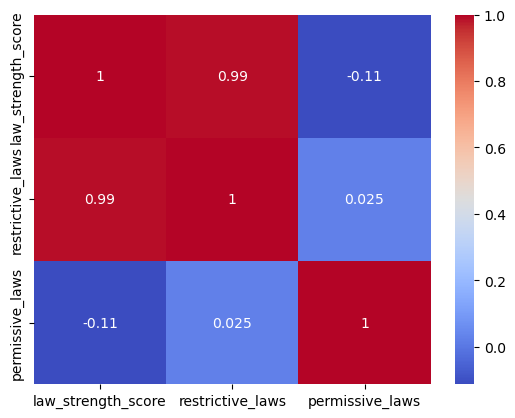

In [18]:
# Check correlation between variables
corr_matrix = model_data[['law_strength_score', 'restrictive_laws', 'permissive_laws']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

High correlation between `law_strength_score` and `restrictive_laws` because `law_strength_score` = `restrictive_laws` - `permissive_laws`. Will exclude `law_strength_score` from model becuase of redundancy. 

In [6]:
X = model_data[['restrictive_laws', 'permissive_laws', 'year']]
y = model_data['rate']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [11]:
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

In [ ]:
pred_model1 = model1.predict(X_test)
rmse_model1 = np.sqrt(mean_squared_error(y_test, pred_model1))
r2_model1 = r2_score(y_test, pred_model1)

RMSE: 3.932 | R^2: 0.486


In [13]:
print(f'Coefficients:')
for name, coef in zip(['restrictive_laws', 'permissive_laws', 'year'], model1.coef_):
    print(f"  {name}: {coef:.4f}")
print(f'Intercept: {model1.intercept_:.4f}')
print(f'Test RMSE: {rmse_model1:.3f} | R^2: {r2_model1:.3f}')

Coefficients:
  restrictive_laws: -0.2589
  permissive_laws: 0.5398
  year: 0.5858
Intercept: -1164.7047
Test RMSE: 3.932 | R^2: 0.486


#### Model 2: K-Nearest Neighbor

In [25]:
scalar = StandardScaler()
X_knn_train = scalar.fit_transform(X_train)
X_knn_test = scalar.transform(X_test)

k_values = range(2, 41, 2)
knn_results = []

for k in k_values:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_knn_train, y_train)
    knn_pred = knn_model.predict(X_knn_test)
    rmse = np.sqrt(mean_squared_error(y_test, knn_pred))
    knn_results.append({'k': k, 'rmse': rmse})

knn_results_df = pd.DataFrame(knn_results)
knn_results_df

,k,rmse
0,2,5.101220
1,4,4.438886
2,6,4.297551
3,8,4.272251
4,10,4.406789
5,12,4.270753
6,14,4.302657
7,16,4.270677
8,18,4.297291
9,20,4.258135


In [34]:
X_test

,restrictive_laws,permissive_laws,year
496,16,7,2018
338,53,4,2020
328,34,7,2020
440,26,11,2022
284,24,6,2016
...,...,...,...
433,24,10,2015
20,20,4,2014
120,23,9,2022
181,21,10,2023


In [35]:
X_train

,restrictive_laws,permissive_laws,year
385,35,6,2017
293,21,6,2015
369,32,6,2021
375,34,9,2017
345,22,4,2017
...,...,...,...
98,23,9,2020
476,26,5,2018
322,25,6,2014
382,35,6,2014


In [37]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(weights='distance'))
])

param_grid = {'knn__n_neighbors': range(1, 41, 2)}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsRegressor(weights='distance'))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 41, 2)},
             scoring='neg_mean_squared_error')

In [38]:
results_df = pd.DataFrame(grid.cv_results_)

results_df["k"] = results_df["param_knn__n_neighbors"]
results_df["mean_score"] = results_df["mean_test_score"]

best_k = grid.best_params_["knn__n_neighbors"]
best_score = grid.best_score_

fig = px.line(
    results_df,
    x="k",
    y="mean_score",
    title=f"Cross-Validated Balanced Accuracy vs. K (best k = {best_k})",
    markers=True,
    labels={"k": "Number of Neighbors (k)", "mean_score": "Mean CV Balanced Accuracy"}
)


fig.add_scatter(
    x=[best_k],
    y=[best_score],
    mode="markers+text",
    text=[f"Best k = {best_k}"],
    textposition="top center",
    name="Best k"
)

fig.update_layout(hovermode="x unified")
fig.show()

# Research Question 3
### Can we identify distinct groups of states based on gun law profiles?


In [8]:
cluster_data = df[df['year'] == 2023][
    ['state_name', 'rate', 'law_strength_score', 
     'restrictive_laws', 'permissive_laws']
].dropna()

# Feature for clustering
cluster_features_df = cluster_data[['law_strength_score', 'restrictive_laws', 
                                     'permissive_laws']]
scaler_cluster = StandardScaler()
cluster_features = scaler_cluster.fit_transform(cluster_features_df)

c:\Users\chloe\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chloe\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chloe\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\chloe\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

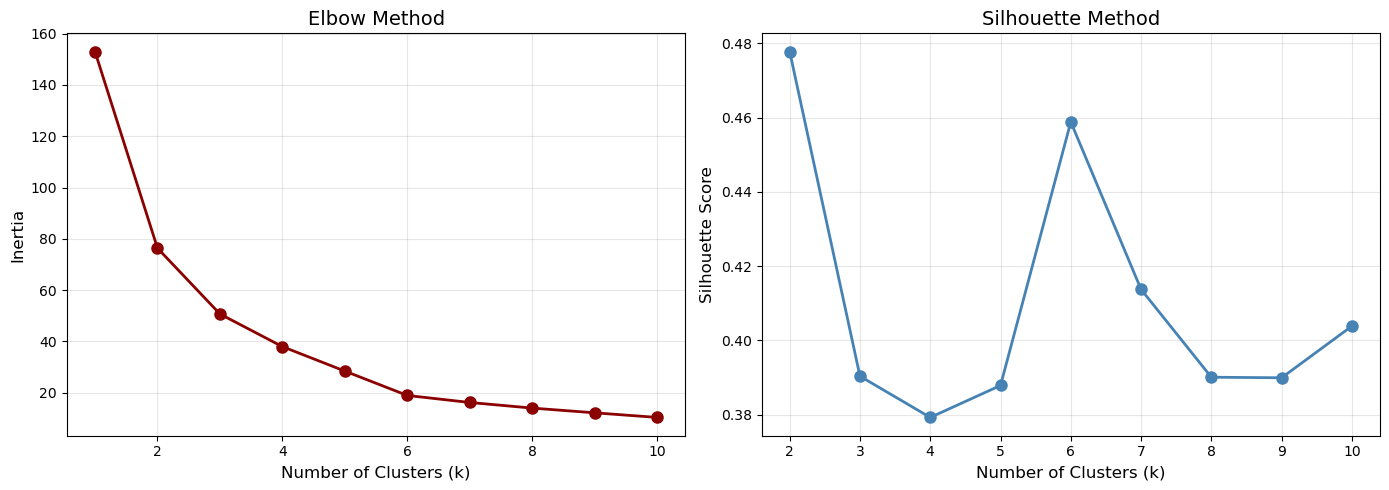

In [10]:
# Determine Optimal Number of Clusters

# Elbow Method
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=25)
    kmeans.fit(cluster_features)
    inertia.append(kmeans.inertia_)

# Silhouette Method
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=25)
    kmeans.fit(cluster_features)
    silhouette_scores.append(silhouette_score(cluster_features, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertia, 'o-', color='darkred', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method', fontsize=14)
ax1.grid(True, alpha=0.3)

ax2.plot(range(2, 11), silhouette_scores, 'o-', color='steelblue', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Method', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Using k=3

kmeans_final = KMeans(n_clusters=3, random_state=123, n_init=25)
cluster_data['cluster'] = kmeans_final.fit_predict(cluster_features)

cluster_summary = cluster_data.groupby('cluster').agg({
    'state_name': 'count',
    'rate': 'mean',
    'law_strength_score': 'mean',
    'restrictive_laws': 'mean',
    'permissive_laws': 'mean'
}).round(2).reset_index()
cluster_summary.rename(columns={'state_name': 'n_states'}, inplace=True)

# Make into dataframe
cluster_summary = pd.DataFrame(cluster_summary)
cluster_summary


c:\Users\chloe\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,cluster,n_states,rate,law_strength_score,restrictive_laws,permissive_laws
0,0,9,9.91,50.56,57.89,7.33
1,1,28,17.36,13.71,22.11,8.39
2,2,14,15.42,25.64,31.21,5.57


In [20]:
# States in each cluster
for cluster in cluster_summary['cluster'].unique():
    print(f"Cluster {cluster}:")
    print(cluster_data[cluster_data['cluster'] == cluster]['state_name'].unique())
    print("\n")

Cluster 0:
['California' 'Connecticut' 'District of Columbia' 'Hawaii' 'Illinois'
 'Massachusetts' 'New Jersey' 'New York' 'Washington']


Cluster 1:
['Alaska' 'Arkansas' 'Arizona' 'Florida' 'Georgia' 'Iowa' 'Idaho'
 'Indiana' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Michigan' 'Minnesota'
 'Missouri' 'Mississippi' 'Montana' 'North Dakota' 'Nebraska'
 'New Hampshire' 'Oklahoma' 'Pennsylvania' 'South Carolina' 'South Dakota'
 'Tennessee' 'Texas' 'Utah' 'Wyoming']


Cluster 2:
['Alabama' 'Colorado' 'Delaware' 'Maryland' 'North Carolina' 'New Mexico'
 'Nevada' 'Ohio' 'Oregon' 'Rhode Island' 'Virginia' 'Vermont' 'Wisconsin'
 'West Virginia']




C:\Users\chloe\AppData\Local\Temp\ipykernel_33060\1109017131.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cluster_data_plot, x='cluster', y='rate', palette='Set2')


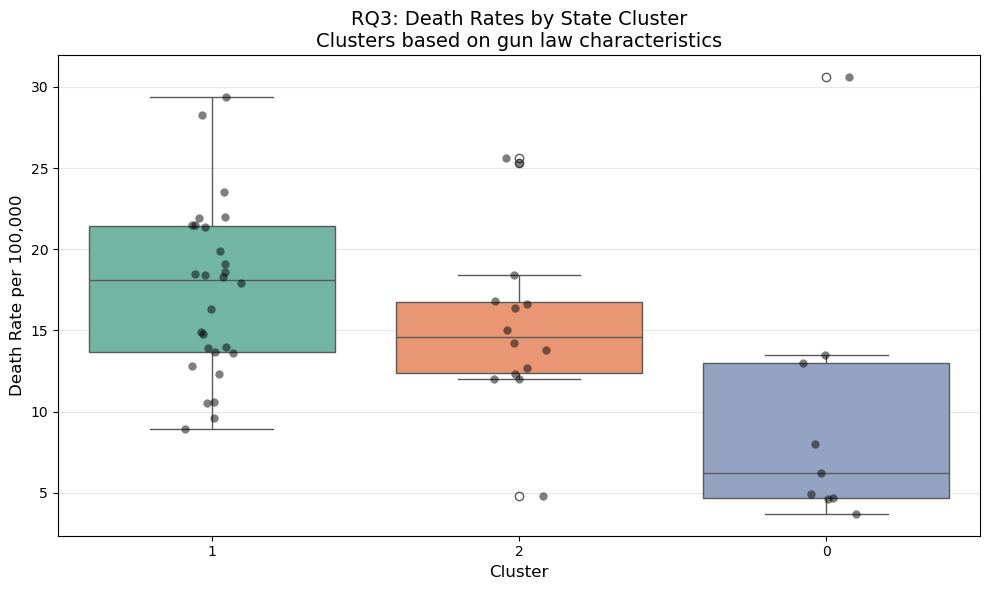

In [22]:
# Death Rates by cluster
plt.figure(figsize=(10, 6))
cluster_data_plot = cluster_data.copy()
cluster_data_plot['cluster'] = cluster_data_plot['cluster'].astype(str)

sns.boxplot(data=cluster_data_plot, x='cluster', y='rate', palette='Set2')
sns.stripplot(data=cluster_data_plot, x='cluster', y='rate', 
              color='black', alpha=0.5, size=6)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Death Rate per 100,000', fontsize=12)
plt.title('RQ3: Death Rates by State Cluster\nClusters based on gun law characteristics', 
          fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

PC1 explains 67.3% of variance
PC2 explains 32.7% of variance


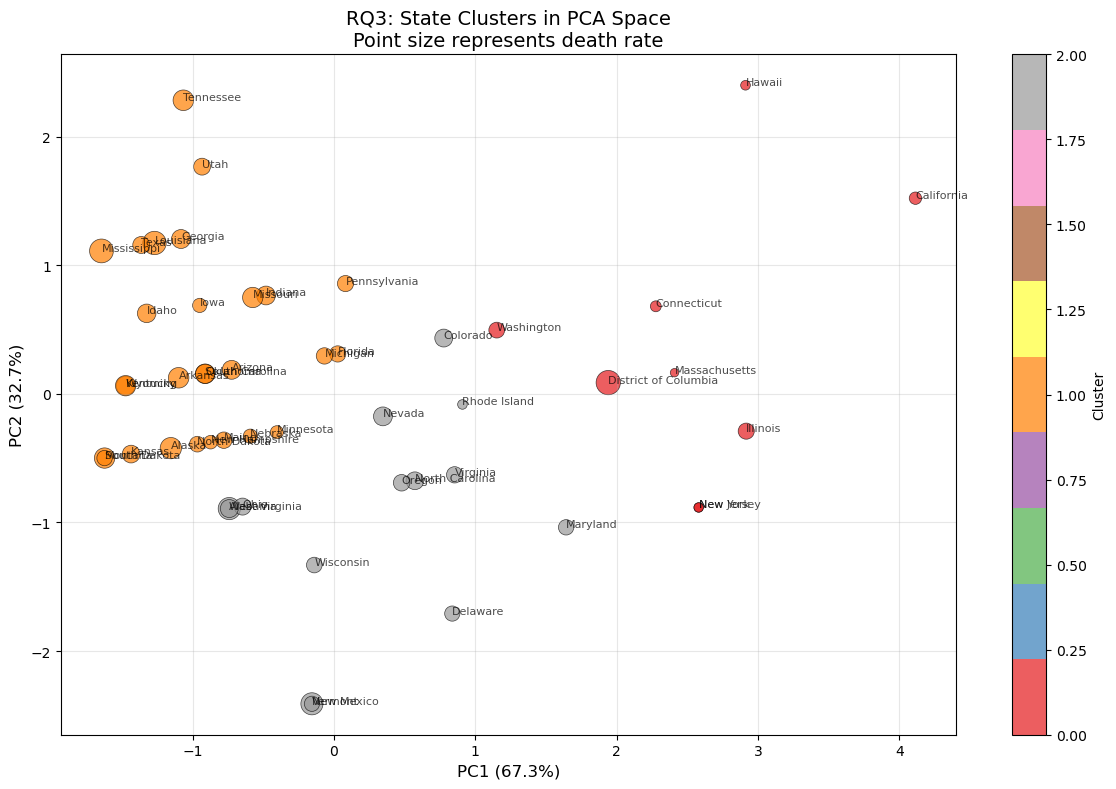

In [23]:
# PCA Visualization of Clusters
pca = PCA(n_components=2)
pca_features = pca.fit_transform(cluster_features)

explained_var = pca.explained_variance_ratio_
print(f"PC1 explains {explained_var[0]*100:.1f}% of variance")
print(f"PC2 explains {explained_var[1]*100:.1f}% of variance")

plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                     c=cluster_data['cluster'], s=cluster_data['rate']*10,
                     cmap='Set1', alpha=0.7, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')

# Add state labels
for i, state in enumerate(cluster_data['state_name']):  
    plt.annotate(state, (pca_features[i, 0], pca_features[i, 1]), 
                fontsize=8, alpha=0.7)

plt.xlabel(f'PC1 ({explained_var[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({explained_var[1]*100:.1f}%)', fontsize=12)
plt.title('RQ3: State Clusters in PCA Space\nPoint size represents death rate', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Research Question 4
### How have gun laws and death rates changed over time?

In [24]:
national_trends = df.groupby('year').agg({
    'rate': 'mean',
    'law_strength_score': 'mean',
    'restrictive_laws': 'mean',
    'permissive_laws': 'mean'
}).round(2)
national_trends.columns = ['avg_rate', 'avg_law_strength', 'avg_restrictive', 'avg_permissive']

print("\nNational Trends:")
print(national_trends)


National Trends:
      avg_rate  avg_law_strength  avg_restrictive  avg_permissive
year                                                             
2014     11.44             20.32            26.60            6.28
2015     12.41             20.60            27.00            6.40
2016     13.05             20.72            27.26            6.54
2017     13.55             20.72            27.46            6.74
2018     13.39             21.40            28.28            6.88
2019     13.43             21.98            28.96            6.98
2020     15.13             22.42            29.42            7.00
2021     16.36             22.54            29.70            7.16
2022     15.78             23.12            30.47            7.35
2023     15.51             23.49            30.92            7.43


In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(national_trends.index, national_trends['avg_rate'],
         'o-', color='darkred', linewidth=2, markersize=8)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Average Death Rate per 100k', fontsize=12)
ax1.set_title('National Average Death Rate Over Time', fontsize=14)
ax1.grid(True, alpha=0.3)

ax2.plot(national_trends.index, national_trends['avg_law_strength'],
         'o-', color='steelblue', linewidth=2, markersize=8)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Average Law Strength Score', fontsize=12)
ax2.set_title('National Average Law Strength Over Time', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures//national_trends.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved: national_trends.png")

Saved: national_trends.png


![National Trends](../reports/figures/national_trends.png "National Trends")

In [26]:
# Calculate change from 2014 to 2023 for each state
state_changes = df[df['year'].isin([2014, 2023])][
    ['state_name', 'year', 'rate', 'law_strength_score']
].pivot_table(
    index='state_name',
    columns='year',
    values=['rate', 'law_strength_score']
).dropna()

state_changes.columns = ["_".join(map(str, col)) for col in state_changes.columns]
state_changes['rate_change'] = state_changes['rate_2023'] - state_changes['rate_2014']
state_changes['law_change'] = state_changes['law_strength_score_2023'] - state_changes['law_strength_score_2014']

In [27]:
plt.figure(figsize=(12, 8))
plt.scatter(state_changes['law_change'], state_changes['rate_change'], 
           s=80, alpha=0.6, edgecolors='black', linewidth=0.5)

# Add trend line
z = np.polyfit(state_changes['law_change'], state_changes['rate_change'], 1)
p = np.poly1d(z)
x_line = np.linspace(state_changes['law_change'].min(), state_changes['law_change'].max(), 100)
plt.plot(x_line, p(x_line), 'r-', linewidth=2, alpha=0.8, label='Trend line')

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Add state labels
for idx, row in state_changes.iterrows():
    plt.annotate(idx, (row['law_change'], row['rate_change']), 
                fontsize=8, alpha=0.7)

plt.xlabel('Change in Law Strength Score (2023 - 2014)', fontsize=12)
plt.ylabel('Change in Death Rate (2023 - 2014)', fontsize=12)
plt.title('Change in Death Rate and Law Strength Over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures//change_over_time.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved: change_over_time.png")

Saved: change_over_time.png


![change over time](../reports/figures//change_over_time.png "Change in Death Rate and Law Strength Over Time")

In [28]:
# Correlation Test
from scipy.stats import pearsonr
corr, p_val = pearsonr(state_changes['law_change'], state_changes['rate_change'])

print(f"\nCorrelation between law changes and rate changes:")
print(f"r = {corr:.3f}, p = {p_val:.4f}")


Correlation between law changes and rate changes:
r = -0.294, p = 0.0383


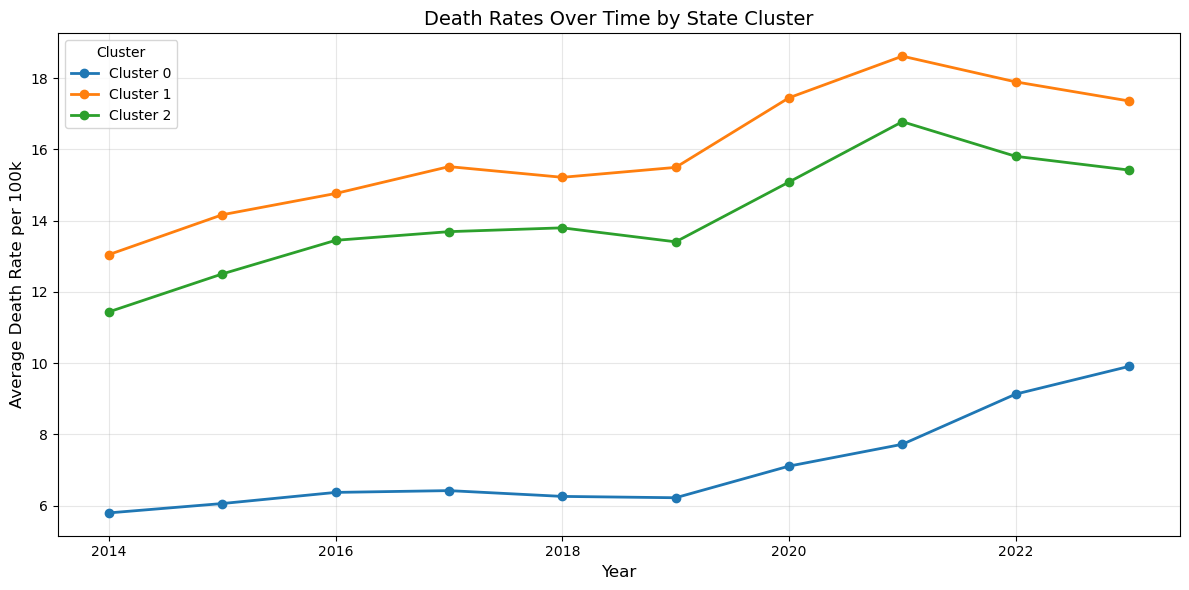

In [29]:
# Time Series by Cluster 

# Merge cluster assignments with full time series
state_clusters = cluster_data[['state_name', 'cluster']]
cluster_trends = df.merge(state_clusters, on='state_name')

cluster_trends_agg = cluster_trends.groupby(['year', 'cluster']).agg({
    'rate': 'mean',
    'law_strength_score': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
for cluster_id in sorted(cluster_trends_agg['cluster'].unique()):    
    data = cluster_trends_agg[cluster_trends_agg['cluster'] == cluster_id]
    plt.plot(data['year'], data['rate'], 'o-', linewidth=2, 
             label=f'Cluster {cluster_id}')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Death Rate per 100k', fontsize=12)
plt.title('Death Rates Over Time by State Cluster', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()



In [30]:
# Mixed Effects Model

import statsmodels.formula.api as smf

# Using composite score to avoid multicollinearity
mixed_data = df[['rate', 'year', 'restrictive_laws', 'permissive_laws', 'state_name']].dropna()

mixed_model = smf.mixedlm("rate ~ year + restrictive_laws + permissive_laws", 
                          mixed_data, 
                          groups=mixed_data["state_name"])
mixed_result = mixed_model.fit()

print("\nMixed Effects Model (Composite Score):")
print(mixed_result.summary())


Mixed Effects Model (Composite Score):
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     rate      
No. Observations:     502         Method:                 REML      
No. Groups:           51          Scale:                  2.1457    
Min. group size:      2           Log-Likelihood:         -1024.7229
Max. group size:      10          Converged:              Yes       
Mean group size:      9.8                                           
--------------------------------------------------------------------
                   Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
Intercept        -1026.162   65.929 -15.565 0.000 -1155.381 -896.944
year                 0.517    0.033  15.589 0.000     0.452    0.582
restrictive_laws    -0.154    0.030  -5.139 0.000    -0.213   -0.095
permissive_laws      0.227    0.136   1.668 0.095    -0.040    0.494
Group Var 